In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

pd.set_option("display.max_rows", 101)
import os
print(os.listdir("../input"))
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import glob
import cv2
import torchvision.models as models
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

['severstal-steel-defect-detection']
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.4 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=df0e29016e35be0ab6dd4367ecc8b5e98323500f45ae1c6fb36901606064b92f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=175771769e7a32a25063dc4505956c378fd0cbfae3146d60f0e36c82d7bb48db
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b

In [3]:
train_df = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")
#train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

sample_df = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/sample_submission.csv")
test_imgs = pd.DataFrame(sample_df['ImageId'].unique(), columns=['ImageId'])
test_imgs.head()

,ImageId
0,0000f269f.jpg
1,000ccc2ac.jpg
2,002451917.jpg
3,003c5da97.jpg
4,0042e163f.jpg


In [4]:
display(train_df[train_df['EncodedPixels'].isna()]);

,ImageId,ClassId,EncodedPixels


In [5]:
print(train_df.shape)
train_df.head()

(7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [6]:
print(sample_df.shape)
sample_df.head()

(5506, 3)


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [7]:
mask_count_df = train_df.groupby('ImageId')['ClassId'].nunique().reset_index()
mask_count_df.columns = ['ImageId', 'Mask_Count']
print(mask_count_df.info())
mask_count_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6666 entries, 0 to 6665
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ImageId     6666 non-null   object
 1   Mask_Count  6666 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 104.3+ KB
None


,ImageId,Mask_Count
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


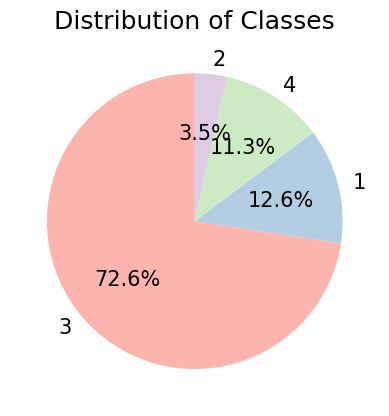

In [8]:
class_distribution = train_df['ClassId'].value_counts()

# Plot pie chart
class_distribution.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Classes')
plt.ylabel('')  # Hide the y-label as it's not necessary for pie charts
plt.show()

Unbalanced dataset Handling

In [9]:
class_distribution = pd.DataFrame(class_distribution)
class_distribution = class_distribution.sort_index()
class_frequencies = class_distribution['count'].values / len(train_df)
alphas = 1.0 / (class_frequencies + 1e-8)
alphas /= alphas.sum()  # Normalize

In [10]:
class_distribution

,count
ClassId,
1,897
2,247
3,5150
4,801


In [11]:
arr = np.zeros(5)
arr[1:] = alphas
alphas = arr
alphas[0] = 0.005

In [12]:
alphas

array([0.005     , 0.16875919, 0.6128622 , 0.02939359, 0.18898501])

In [13]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    masks = np.zeros((*input_shape, 4))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

Transform

In [14]:
TRANSFORMS = transforms.Compose([
    transforms.Resize((256, 1600)),
    transforms.RandomVerticalFlip(0.6),
    transforms.RandomHorizontalFlip(0.6),
    #transforms.RandomAffine(degrees=(0, 15), translate=(0, 0.15), scale=(0.85, 1.15)),
    #transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    #transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
    #transforms.ToTensor()
])

Dataset

In [15]:
len(train_df['ImageId'].unique())

6666

In [16]:
type(train_df[train_df['ImageId'] == '0002cc93b.jpg'].values[0,2])

str

In [17]:
class SteelDataset(Dataset):
    def __init__(self, mode, directory, df, n_channels=1, dim=(256, 1600), transform=None):
        super(SteelDataset, self).__init__()
        self.transform = transform
        self.mode = mode
        self.directory = directory
        self.dim = dim
        self.len = len(df['ImageId'].unique())
        self.df = df
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        name = self.df['ImageId'].iloc[idx]
        #print(name)
        path = os.path.join(self.directory, self.mode, name)
        img = self.__load_grayscale(path)
        
        if self.mode == 'train_images':
            rles = self.df[self.df['ImageId'] == name].values;
            masks = self.__gen_mask(rles)
        
            if self.mode == 'train':
                if self.transform is not None:
                    img = self.transform(img)
                    masks = self.transform(masks)
            
            return img, masks
        else:
            return img
        
    def rle2mask(self, cls_id, rle, mode='one_channel'):
        width, height = self.dim[:2]
    
        mask= np.zeros( width*height ).astype(np.uint8)
    
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        
        if mode=='one_channel':
            for index, start in enumerate(starts):
                mask[int(start):int(start+lengths[index])] = cls_id
                current_position += lengths[index]
            return mask.reshape(height, width).T
        else:
            for index, start in enumerate(starts):
                mask[int(start):int(start+lengths[index])] = 1
                current_position = lengths[index]
            return mask.reshape(height, width).T
    
    def __build_mask_one_channel(self, rles):
        masks = np.zeros(self.dim)
    
        for row in rles:
            _, i, rle = row
            if type(rle) is str:
                masks[:, :] += self.rle2mask(i, rle)
    
        assert np.all(masks <= 4), "Not all elements are less than 4!"
        
        return masks
        
    def __build_mask(self, rles):
        masks = np.zeros((4, *self.dim))
    
        for row in rles:
            _, i, rle = row
            if type(rle) is str:
                masks[i-1, :, :] += self.rle2mask(i, rle, 'mulli_channel')
                
        return masks
    
    def __load_grayscale1(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_grayscale(self, img_path):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        tensor_image = torch.from_numpy(image).float()

        # Normalize the image tensor to [0, 1]
        tensor_image /= 255.0
        
        #print(tensor_image.shape)

        tensor_image = tensor_image.unsqueeze(0)
        
        return tensor_image
    
    def __gen_mask(self, rles):
        #print(rles)
        masks = self.__build_mask(rles)
        #print(masks)
        masks = torch.tensor(masks, dtype=torch.uint8)
        return masks

In [18]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(42)

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler

BATCH_SIZE = 2
random_seed= 42
validation_split = 0.15
shuffle_dataset = True
root = '/kaggle/input/severstal-steel-defect-detection'

train_dataset = SteelDataset('train_images', root, train_df, transform=TRANSFORMS)
sub_dataset = SteelDataset('test_images', root, sample_df)

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True, drop_last=False)
sub_dataloader = DataLoader(sub_dataset, BATCH_SIZE, drop_last=False)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=BATCH_SIZE,
        #shuffle = True,
        drop_last=False
    )
val_loader = DataLoader(
        train_dataset,
        sampler=valid_sampler,
        batch_size=BATCH_SIZE,
        drop_last=False
    )

In [20]:
img, masks = train_dataset.__getitem__(4000)
print(img.shape)
print(masks.shape)

torch.Size([1, 256, 1600])
torch.Size([4, 256, 1600])


In [34]:
(masks > 0).sum().item()

12436

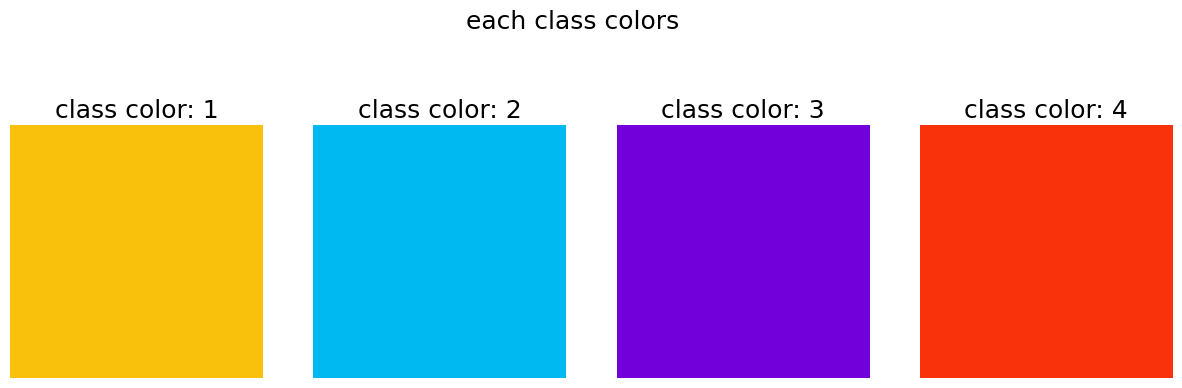

In [35]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [27]:
def show_mask_image(name, mask):
    path = os.path.join(root, 'train_images', name)
    img = cv2.imread(path)
    fig, ax = plt.subplots(figsize=(15, 15))

    if torch.is_tensor(mask):
        mask = mask.numpy()
    
    for ch in range(4):
        contours, _ = cv2.findContours(mask[ch, :, :], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

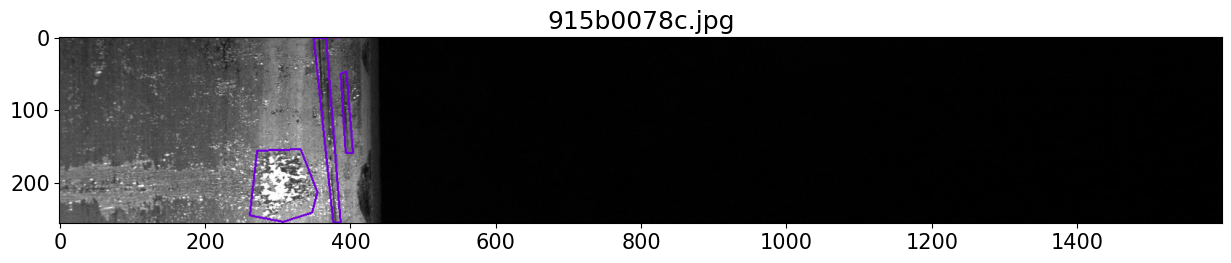

In [29]:
show_mask_image(train_df['ImageId'].iloc[4000], masks)

Model

In [36]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Unet1(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Unet1, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 8)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(8, 16))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(16, 32))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(32, 64))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down5 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(64, 32)
        self.up4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(32, 16)
        self.up5 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(16, 8)

        self.outc = nn.Conv2d(8, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        
        x = self.up1(x6)
        x = self.conv1(torch.cat([x, x5], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x4], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x3], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x2], dim=1))
        x = self.up5(x)
        x = self.conv5(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits
    

class UNetResNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNetResNet, self).__init__()
        
        # Load pre-trained ResNet-18 as the encoder
        self.inc = DoubleConv(n_channels, 16)
        self.encoder = models.resnet18(weights='DEFAULT')
        
        self.encoder.conv1 = nn.Conv2d(16, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder1 = nn.Sequential(*list(self.encoder.children())[:3])  # initial conv and first layer
        self.encoder2 = nn.Sequential(*list(self.encoder.children())[3:5]) # layer1
        self.encoder3 = nn.Sequential(*list(self.encoder.children())[5])   # layer2
        self.encoder4 = nn.Sequential(*list(self.encoder.children())[6])   # layer3
        self.encoder5 = nn.Sequential(*list(self.encoder.children())[7])
        
        # Define the decoder (transposed convolutional layers)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(96, 32)
        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(32, 16)

        self.outc = nn.Conv2d(16, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)#[4, 16, 128, 800]
        x2 = self.encoder1(x1)#torch.Size([4, 64, 128, 800])
        #print(x2.shape)
        x3 = self.encoder2(x2)#torch.Size([4, 64, 64, 400])
        #print(x3.shape)
        x4 = self.encoder3(x3)#torch.Size([4, 128, 32, 200])
        #print(x4.shape)
        x5 = self.encoder4(x4)#torch.Size([4, 256, 16, 100])
        #print(x5.shape)
        x6 = self.encoder5(x5)#torch.Size([4, 512, 8, 50])
        #print(x6.shape)
        
        # Decoder
        x = self.up1(x6)#[4, 256, 16, 100]
        x = self.conv1(torch.cat([x, x5], dim=1))
        x = self.up2(x)#[4, 128, 32, 200]
        x = self.conv2(torch.cat([x, x4], dim=1))
        x = self.up3(x)#[4, 64, 64, 400]
        x = self.conv3(torch.cat([x, x3], dim=1))
        x = self.up4(x)#[4, 32, 128, 800]
        x = self.conv4(torch.cat([x, x2], dim=1))
        x = self.up5(x)#[4, 32, 256, 1600]
        x = self.conv5(torch.cat([x, x1], dim=1))
        
        return self.outc(x)

Loss function

In [37]:
class FocalLoss(nn.Module):
    def __init__(self, alphas, gamma=2.0, reduction='mean'):
        """
        Initializes the focal loss function.

        Parameters:
        - alpha (float): Weighting factor for the class (0.25 is used in the original focal loss paper for binary classification).
        - gamma (float): Focusing parameter to adjust the rate at which easy examples are down-weighted.
        - reduction (str): Specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.alphas = alphas
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Forward pass of the focal loss.

        Parameters:
        - inputs (torch.Tensor): Predictions from the model (before softmax).
        - targets (torch.Tensor): True class labels.
        """
        # Assuming inputs are of shape [batch_size, num_classes, height, width]
        # and targets are of shape [batch_size, height, width]
        B, C, H, W = inputs.size()
        p = F.softmax(inputs, dim=1)
        
        # Ensure targets are compatible for advanced indexing
        targets = targets.long()
        
        # Get the probabilities of the true class for each pixel
        p_t = p.gather(1, targets.unsqueeze(1)).squeeze(1)#[B, H, W]
        
        if torch.is_tensor(self.alphas) == False:
            self.alphas = torch.tensor(self.alphas)
        
        self.alphas = self.alphas.to(device)
        
        # Apply dynamic alpha to the corresponding target classes
        alpha_factor = self.alphas[targets.view(-1)].view(B, H, W)
        
        # Calculate the focal loss
        focal_loss = -alpha_factor * ((1 - p_t) ** self.gamma) * torch.log(p_t)

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU
    
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.8, beta=0.8):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
        
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1).float()
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets)
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

Utility functions

In [ ]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [49]:
def dice_coef(pred_mask, true_mask, smooth=1):
    #pred_mask = F.softmax(pred_mask, dim=1)
    #_, pre_index = torch.max(pred_mask, 1)
     # Convert tensors to numpy arrays
#     pred_mask_np = pre_index.cpu().detach().numpy()
#     true_mask_np = true_mask.cpu().detach().numpy()
    pred_mask = F.sigmoid(pred_mask)       
        
    #flatten label and prediction tensors
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1).float()
        
    intersection = (pred_mask * true_mask).sum()   
    
    union = pred_mask.sum() + true_mask.sum()
    
    # Calculate Dice coefficient
    dice = (2.0 * intersection+smooth) / (union+smooth)
    
    return dice

def calculate_mask_accuracy(pred_mask, true_mask):
    """
    Calculate the accuracy of a semantic segmentation model with PyTorch tensors.
    
    Parameters:
    - pred_mask: 2D PyTorch tensor, predicted segmentation mask. [batch_size, num_class, w, h]
    - true_mask: 2D PyTorch tensor, ground truth segmentation mask.
    
    Returns:
    - accuracy: float, the accuracy of the segmentation.
    """
    _, pre_index = torch.max(pred_mask, 1)
    assert pre_index.shape == true_mask.shape, "The shape of pre_index and true_mask must be the same."
    
    target_pixels = torch.zeros_like(true_mask, dtype=torch.bool)
    target_pixels[torch.where(true_mask > 0)] = True
    predictions = pre_index[target_pixels]
    labels = true_mask[target_pixels]
    
    # Calculate the total number of correctly predicted pixels
    correct_predictions = torch.sum(predictions == labels)
    
    # Calculate the total number of pixels
    total_pixels = torch.numel(labels)
    
    # Calculate the accuracy
    if total_pixels != 0:
        accuracy = correct_predictions.float() / total_pixels
        return accuracy.item()  # Convert to Python scalar
    
    print("label has no mask!")
    return 1

def train_one_epoch_unet(model, cretiria, optimizer, dataloader):
    global global_step, print_freq, train_loss_avg
    model.train()
    cnt = 0
    sum_train_loss = 0
    for grids, labels in iter(dataloader):
        grids = grids.to(device)
        labels = labels.to(device)#.squeeze(1)
        output = model(grids)#.squeeze(1)
#         print(output.shape)
#         print(labels.shape)
        loss = cretiria(output, labels)
        sum_train_loss += loss
        cnt += 1
        if (global_step+1) % print_freq == 0:
            print('{step} th training steps, the train loss is: {loss}'.format(step=global_step, loss=loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        global_step += 1
        
    train_loss_avg.append(sum_train_loss / cnt)
    
    
def evaluation_unet(model, cretiria, dataloader):
    global val_loss_avg, val_dc_avg
    model.eval()
    cnt = 0
    sum_eval_loss = 0
    #sum_acc = 0
    sum_dc = 0
    #outputs = []
    for grids, labels in iter(dataloader):
        grids = grids.to(device)
        labels = labels.to(device)#.squeeze(1)
        with torch.no_grad():
            output = model(grids)#.squeeze(1)
        loss = cretiria(output, labels)
        #acc = calculate_mask_accuracy(output, labels)
        dc = dice_coef(output, labels)
        sum_eval_loss += loss
        #sum_acc += acc
        sum_dc += dc
        cnt += 1
        if cnt % print_freq == 0:
            print('{step} th validating steps, the validating loss is: {loss}'.format(step=cnt, loss=loss))
            #print('{step} th validating steps, the validating acc is: {acc}'.format(step=cnt, acc=acc))
            print('{step} th validating steps, the validating dice_coef is: {dc}'.format(step=cnt, dc=dc))
        
    val_loss_avg.append(sum_eval_loss / cnt)
    #val_acc_avg.append(sum_acc / cnt)
    val_dc_avg.append(sum_dc / cnt)
    
    #return outputs

In [51]:
global_step = 0
print_freq = 800 / BATCH_SIZE
epochs = 10
val_loss_avg = []
val_dc_avg = []
train_loss_avg = []

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4 #4 classes and 1 background
#model = Unet1(n_channels=1, n_classes=num_classes).to(device)
#model = UNetResNet(n_channels=1, n_classes=num_classes).to(device)


model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*1000)

#cretiria = FocalLoss()
#cretiria = DynamicFocalLoss()
#cretiria = FocalLoss(alphas=alphas, gamma=2.0, reduction='mean')#nn.CrossEntropyLoss()
#cretiria = nn.MSELoss()
cretiria = DiceBCELoss()

In [53]:
def train(model, epochs, cretiria, optimizer, train_loader, val_loader):
    global global_step, print_freq, val_loss_avg, val_dc_avg, train_loss_avg
    
    for epoch in range(epochs):
        print("----------{} th epoch training start----------".format(epoch))
        train_one_epoch_unet(model, cretiria, optimizer, train_loader)
    
        print("{} th epoch validation start...".format(epoch))
        evaluation_unet(model, cretiria, val_loader)
    
        #if epoch > epochs//2:
        if os.path.exists('check_points') == False:
            os.mkdir('check_points')
            print('created check_points folder')
        torch.save(model.state_dict(), 
            'check_points/checkpoint_{}_epoch.pth'.format(epoch))
    

In [54]:
train(model, epochs, cretiria, optimizer, train_loader, val_loader)

----------0 th epoch training start----------
399 th training steps, the train loss is: 0.8182021379470825
799 th training steps, the train loss is: 0.7334693670272827
1199 th training steps, the train loss is: 0.42324432730674744
1599 th training steps, the train loss is: 1.0558022260665894
1999 th training steps, the train loss is: 0.7154299020767212
2399 th training steps, the train loss is: 0.8360032439231873
2799 th training steps, the train loss is: 0.7296340465545654
0 th epoch validation start...
400 th validating steps, the validating loss is: 1.1035481691360474
400 th validating steps, the validating dice_coef is: 0.06927010416984558
----------1 th epoch training start----------
3199 th training steps, the train loss is: 0.21349363029003143
3599 th training steps, the train loss is: 0.9089070558547974
3999 th training steps, the train loss is: 0.27574968338012695
4399 th training steps, the train loss is: 0.692396342754364
4799 th training steps, the train loss is: 0.52280861